<h1><center><font size="6">Santander Bank Customer Transaction Prediction Model</font></center></h1>

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg/640px-Another_new_Santander_bank_-_geograph.org.uk_-_1710962.jpg"></img>

<br>
<b>
Santander Bank invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem. 
The data is anonimyzed, each row containing 200 numerical values identified just with a number.</b>



<pre>
<a id='0'><b>Content</b></a>
- <a href='#1'><b>Import the Data</b></a>
- <a href='#11'><b>Data Exploration</b></a>  
- <a href='#2'><b>Check for the missing values</b></a>  
- <a href='#3'><b>Visualizing the Satendar Customer Transactions Data</b></a>   
 - <a href='#31'><b>Check for Class Imbalance</b></a>   
 - <a href='#32'><b>Distribution of Mean and Standard Deviation</b></a>   
 - <a href='#33'><b>Distribution of Skewness</b></a>   
 - <a href='#34'><b>Distribution of Kurtosis</b></a>   
- <a href='#4'><b>Principal Component Analysis</b></a>
 - <a href='#41'><b>Kernel PCA</b></a>
- <a href = "#16"><b>Data Augmentation</b></a>
- <a href='#6'><b>Build the Light GBM Model</b></a></pre>

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

<a id=1><pre><b>Import the Data</b></pre></a>

In [2]:
#Load the Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
features = [c for c in train.columns if c not in ['ID_code', 'target']]

<a id=11><pre><b>Data Exploration</b></pre></a>

In [3]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [5]:
train.shape

(200000, 202)

In [6]:
train.head(5)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


<a id=2><b><pre>Check for the Missing Values.</pre></b></a> 

In [7]:
#Check for Missing Values after Concatination

obs = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
var_199,0,0.0
var_61,0,0.0
var_71,0,0.0
var_70,0,0.0
var_69,0,0.0
...,...,...
var_129,0,0.0
var_128,0,0.0
var_127,0,0.0
var_126,0,0.0


<pre>There are no missing values in the dataset</pre>

<pre><a id = 3><b>Visualizing the Satendar Customer Transactions Data</b></a></pre>

<pre><a id = 31 ><b>Check for Class Imbalance</b></a></pre>

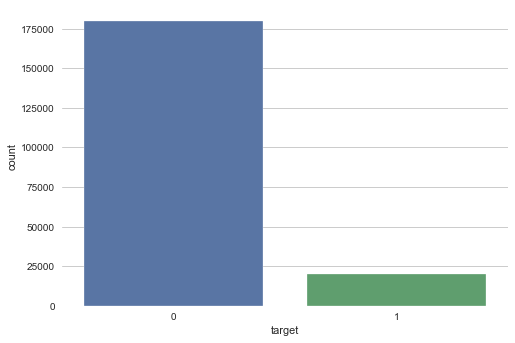

In [8]:
target = train['target']
train = train.drop(["ID_code", "target"], axis=1)
sns.set_style('whitegrid')
sns.countplot(target)

<pre><a id = 32 ><b>Distribution of Mean and Standard Deviation</b></a></pre>

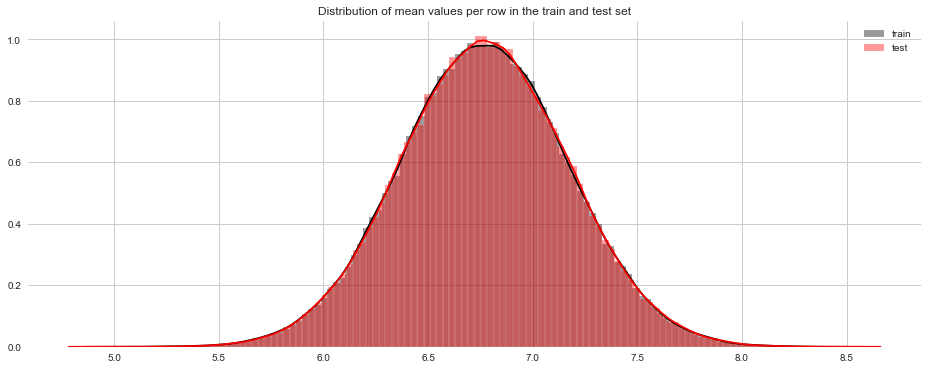

In [9]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

<pre>Let's check the distribution of the mean of values per columns in the train and test datasets.</pre>

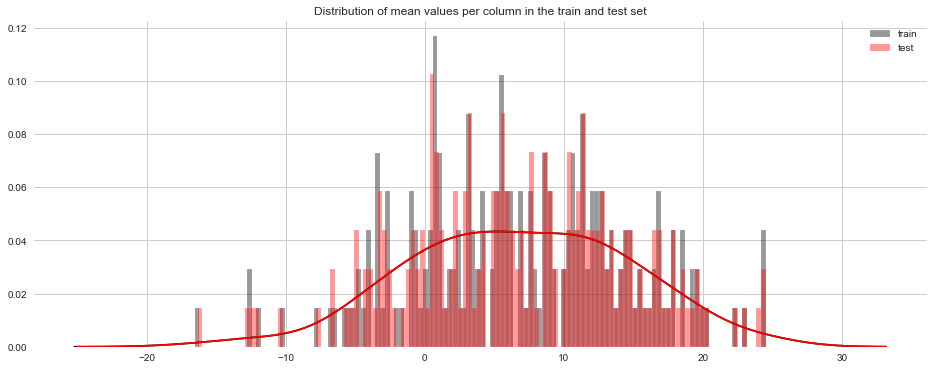

In [10]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

<pre>Distribution for Standard Deviation</pre>

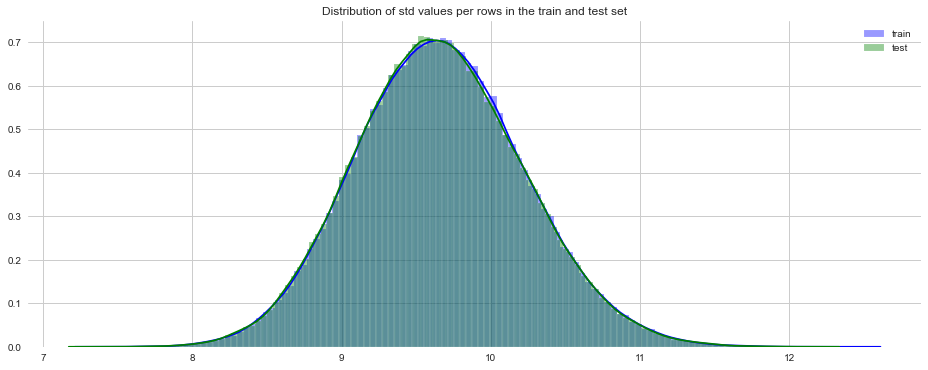

In [11]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per rows in the train and test set")
sns.distplot(train[features].std(axis=1),color="blue",kde=True,bins=120, label='train')
sns.distplot(test[features].std(axis=1),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

<pre>Let's check the distribution of the standard deviation of values per columns in the train and test datasets.</pre>

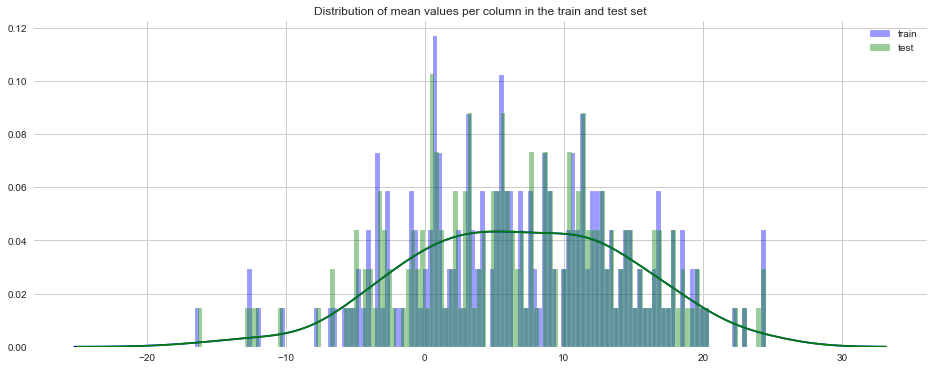

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train[features].mean(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend();plt.show()

<pre>Let's check now the distribution of the mean value per row in the train dataset, grouped by value of target</pre>

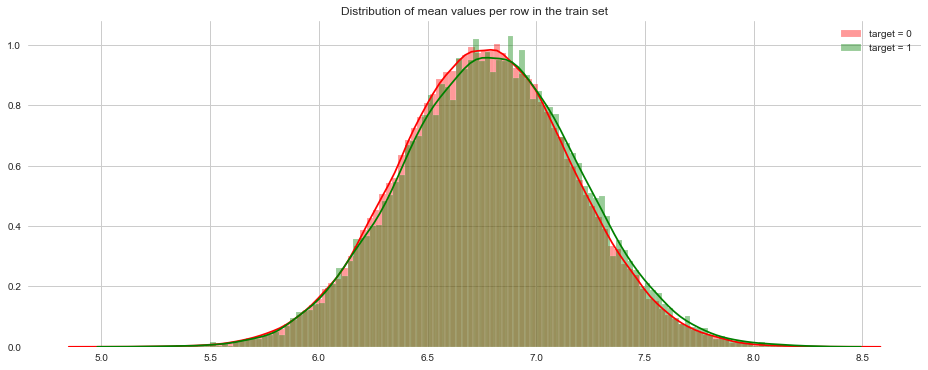

In [13]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<pre>Let's check now the distribution of the mean values per columns in the train and test datasets.</pre>

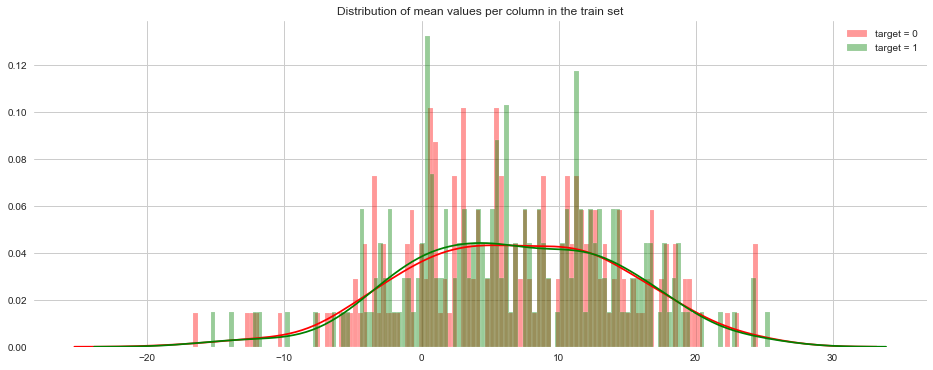

In [14]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<pre>Let's check now the distribution of the standard deviation  per row in the train dataset, grouped by value of target</pre>

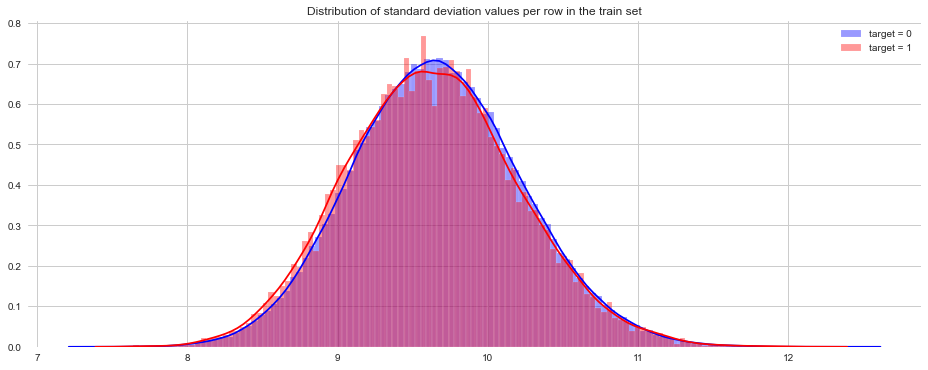

In [15]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per row in the train set")
sns.distplot(t0[features].std(axis=1),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=1),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<pre>Let's check now the distribution of standard deviation per columns in the train and test datasets.</pre>

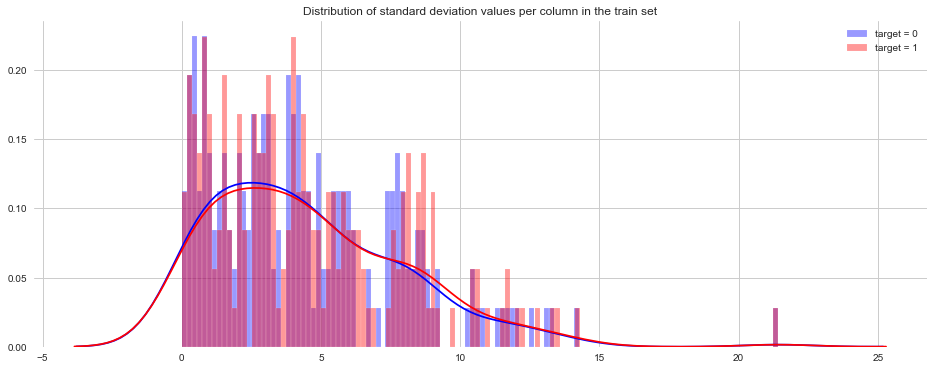

In [16]:
t0 = train.loc[target  == 0]
t1 = train.loc[target  == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of standard deviation values per column in the train set")
sns.distplot(t0[features].std(axis=0),color="blue", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].std(axis=0),color="red", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<pre><a id = 33 ><b>Distribution of Skewness</b></a></pre>

<pre>Let's see now the distribution of skewness on rows in train separated for values of target 0 and 1. We found the distribution is left skewed</pre>

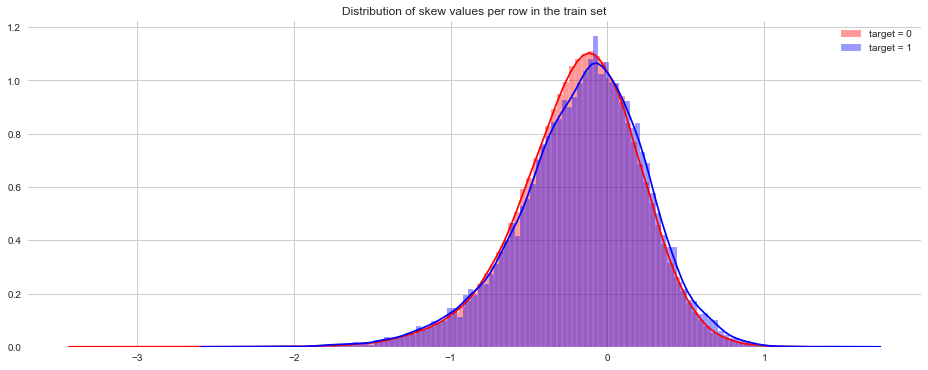

In [17]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<pre>Let's see now the distribution of skewness on columns in train separated for values of target 0 and 1.</pre>

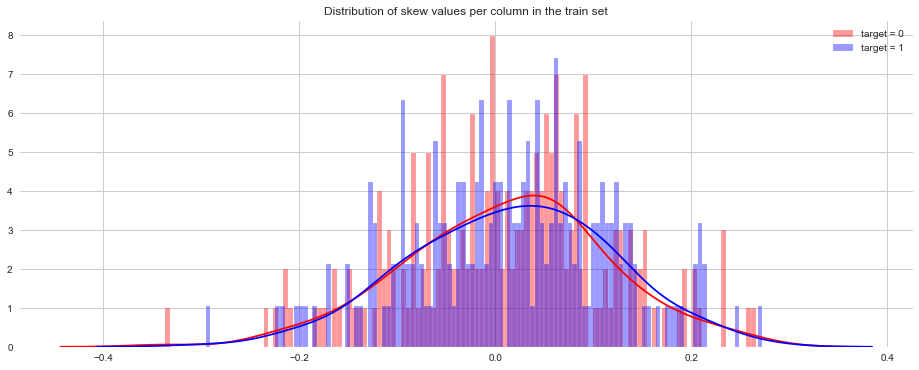

In [18]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<pre><a id = 34 ><b>Distribution of Kurtosis</b></a></pre>

<pre>Let's see now the distribution of kurtosis on rows in train separated for values of target 0 and 1. We found the distribution to be Leptokurtic</pre>

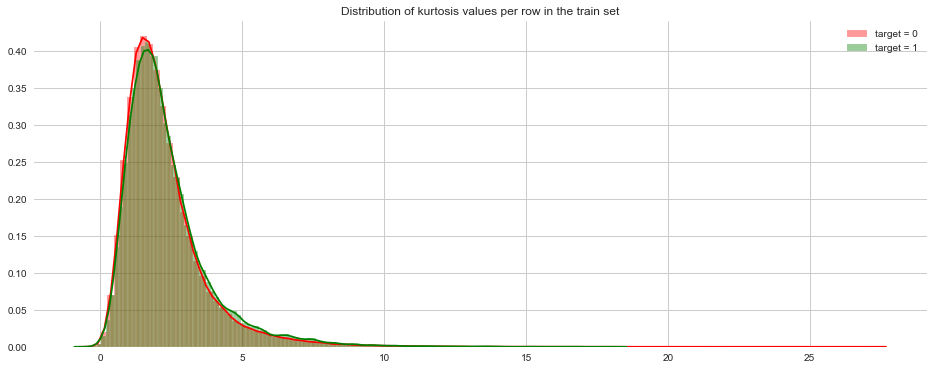

In [19]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<pre>Let's see now the distribution of kurtosis on columns in train separated for values of target 0 and 1.</pre>

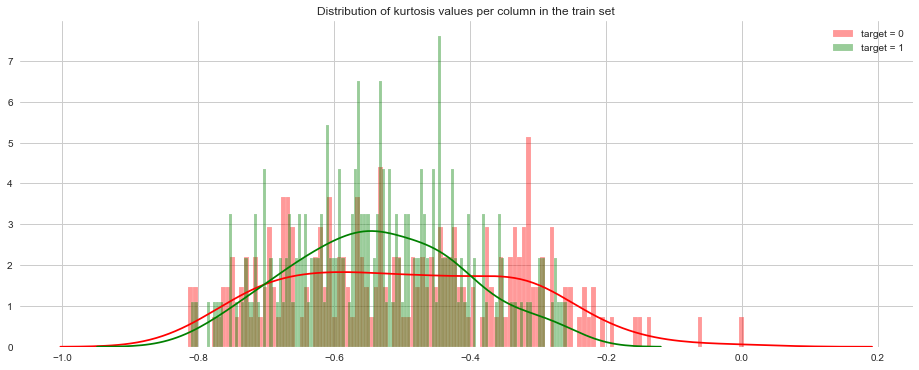

In [20]:
t0 = train.loc[target == 0]
t1 = train.loc[target == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

<a id=4><pre><b>Principal Component Analysis to check Dimentionality Reduction<b></pre></a>

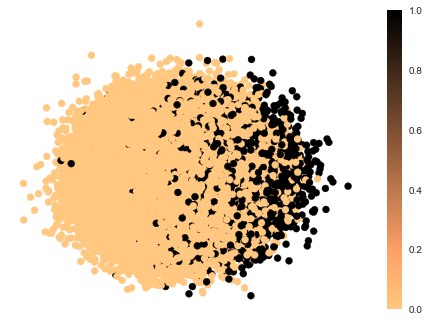

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

<pre><a id = 41><b>Kernel PCA (Since the Graph above doesn't represent meaningful analysis)</b></a></pre>

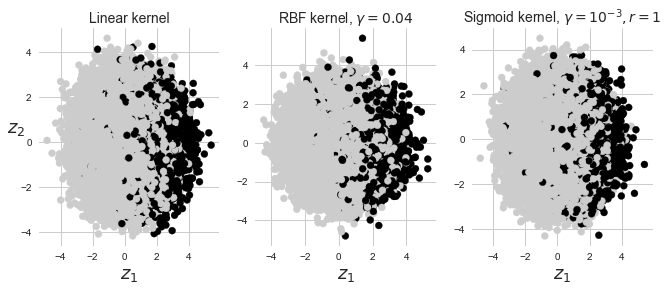

In [22]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

<pre>Since PCA hasn't been useful, I decided to proceed with the existing dataset</pre>

<pre><a id = 16><b>Data Augmentation</b></a></pre>

In [23]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

<pre><a id = 6><b>Build the Light GBM Model</b></a></pre>

In [24]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [25]:
train.shape

(200000, 200)

In [28]:
num_folds = 11
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.90899	valid_1's auc: 0.8934
[10000]	training's auc: 0.921198	valid_1's auc: 0.899973
[15000]	training's auc: 0.929112	valid_1's auc: 0.901135
[20000]	training's auc: 0.936042	valid_1's auc: 0.900976
Early stopping, best iteration is:
[16679]	training's auc: 0.931525	valid_1's auc: 0.901338
Fold idx:2
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.90959	valid_1's auc: 0.891068
[10000]	training's auc: 0.921765	valid_1's auc: 0.897038
[15000]	training's auc: 0.929677	valid_1's auc: 0.898043
[20000]	training's auc: 0.936498	valid_1's auc: 0.897726
Early stopping, best iteration is:
[16058]	training's auc: 0.931178	valid_1's auc: 0.898115
Fold idx:3
Training until validation scores don't improve for 4000 rounds
[5000]	training's auc: 0.910229	valid_1's auc: 0.885835
[10000]	training's auc: 0.922399	valid_1's auc: 0.89189
[15000]	training

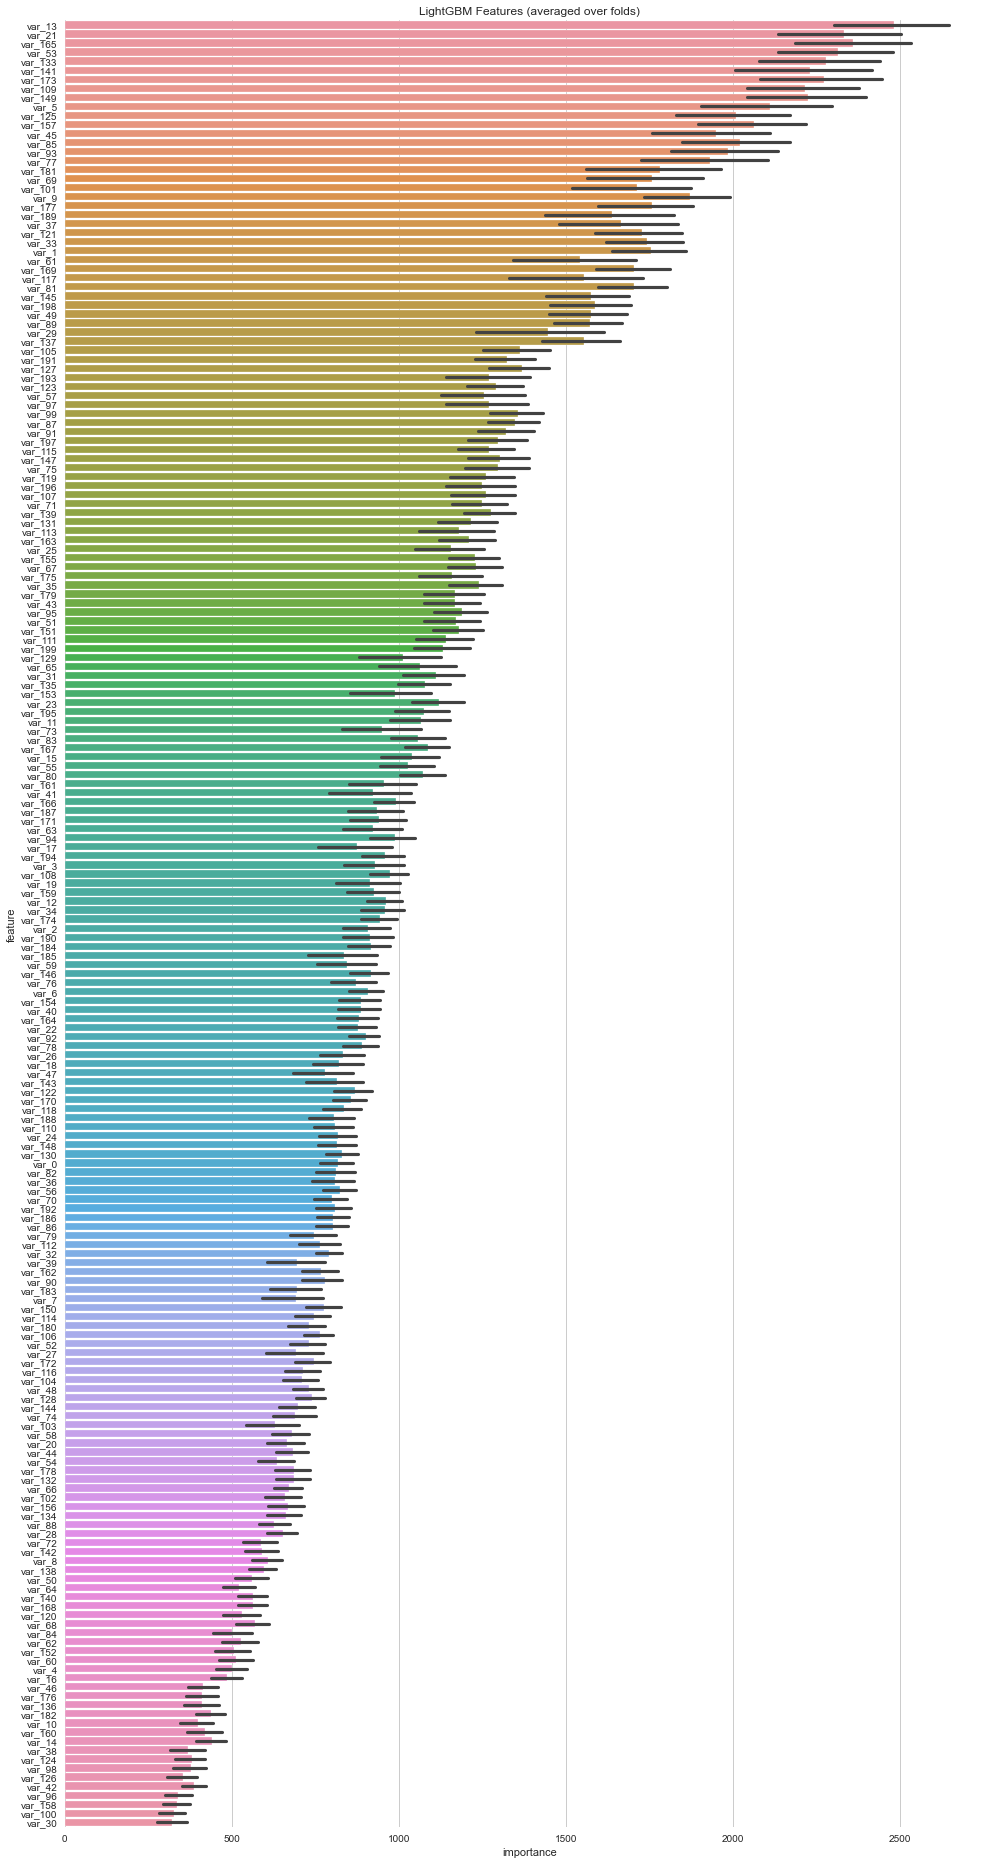

In [29]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [30]:
num_sub = 26
print('Saving the Submission File')
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = predictions
sub.to_csv('submission{}.csv'.format(num_sub), index=False)
getValue = pd.DataFrame(getVal)
getValue.to_csv("Validation_kfold.csv")

Saving the Submission File
